## PREDICTION TASK 2 (Using the Weekly Data)

This model uses the weekly dataset that has new additional features like Weekly_Avg_Pct_Home, Incident_Rate_Last_week, Incident_Rate_Pct_Change_Last_week. However due to categorizing the data week by week, the input dataset is smaller than the daily dataset. The goal of the model is to predict top 20 states that will see most change in incident rate over a period of 2 weeks between May 10-24.
The logic here is that by having an element of history as the memory of the trend, we can estimate changes of incident rate for the next week better.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as CrossValidate
from matplotlib.pyplot import rcParams
from sklearn.metrics import mean_absolute_error

plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from patsy import dmatrices
import statsmodels.api as sm


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.2.0
Eager execution: True


In [0]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [0]:
#importing the train set
X_tr = pd.read_csv('../data/X_weekly_tr.csv')   
y_tr = pd.read_csv('../data/y_weekly_change_tr.csv') 

#importing the test set
X_te = pd.read_csv('../data/X_weekly_te.csv')   
y_te = pd.read_csv('../data/y_weekly_change_te.csv') 

In [0]:
train_timestamps = X_tr['Date'].values
test_timestamps = X_te['Date'].values

In [0]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)

In [6]:
# just to make sure if any Null is left
print ("number of nulls left in X_tr is ", len(X_tr[X_tr.isnull().values == True].head()))
print ("number of nulls left in X_te is ", len(X_te[X_te.isnull().values == True].head()))

number of nulls left in X_tr is  0
number of nulls left in X_te is  0


In [7]:
X_tr.describe()

,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
count,436.000000,436.000000,436.000000,436.000000
mean,36.968382,29.350917,115.964551,2.897401
std,6.596189,17.847071,212.076329,4.995127
min,21.758841,0.000000,0.003449,0.000000
25%,32.912088,14.000000,6.271094,0.333152
50%,37.020951,29.000000,45.478209,0.857425
75%,41.261225,45.000000,121.404014,3.256551
max,61.343387,67.000000,1626.514549,34.000000


In [8]:
y_tr.describe()

,Weekly_Incident_Rate_Pct_Change
count,436.000000
mean,1.753532
std,3.187174
min,0.000000
25%,0.254785
50%,0.500422
75%,1.890815
max,31.000000


In [0]:
#standardizing the train and test data from the previously fitted standardizers
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std = standardize_transfrom2(X_tr, scaler, encoder2)
X_te_std = standardize_transfrom2(X_te, scaler, encoder2)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_std,y_tr.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_te_std,y_te.values))

batch_size = 8

train_dataset = train_dataset.batch(batch_size)
test_dataset= test_dataset.batch(batch_size)

X,y = next(iter(train_dataset))
_, num_features = X.shape

In [0]:
## Define Poisson loss and gradient

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=training)

    return tf.keras.losses.poisson(y,logits)

## Gradient tape lets TF know with respect to what to take gradients
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# these are the proposed Artificial Neural Network Architectures for this prediction Task
early_stop_delta = 0.001
early_stop_patience = 100
num_epochs = 300

models =[]

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim= num_features, activation="relu"), 
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim= num_features, activation="sigmoid"), 
  tf.keras.layers.Dense(32, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim= num_features, activation="relu"), 
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim= num_features, activation="sigmoid"), 
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, input_dim= num_features, activation="relu"), 
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, input_dim= num_features, activation="sigmoid"), 
  tf.keras.layers.Dense(1, activation="sigmoid")
])
models.append(model)

In [13]:
## Training Model
# we have set up early stopping by looking at the training loss. The maximum epoch count is 300
# Unfortunately due to having a timestamped data, the crossvalidation isn't easy, so we are only training on the training set and early stop will help with not overfittig

histories=[]
scores= []

prevLoss = np.Inf
best_score = np.Inf

patience_cnt = 0

m = 0
for model in models:
    history= {}
    train_loss_results = []
    train_accuracy_results = []
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
        
        # Training loop - using batches of 8
        for x, y in train_dataset:
            # Optimize the model
            loss_value, grads = grad(model, x, y)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))       

            # Track progress
            epoch_loss_avg.update_state(loss_value)  # Add current batch loss
            epoch_accuracy.update_state(y, model(x, training= True))
        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        # Early stopping monitor
        if np.abs(train_loss_results[-1].numpy() - prevLoss) < early_stop_delta:
            patience_cnt += 1
        else:
            prevLoss = train_loss_results[-1].numpy()
            # patience_cnt = 0           
        if patience_cnt >= early_stop_patience:
            break

    history['loss'] = train_loss_results
    history['mae'] = train_accuracy_results
    histories.append(history)
    y_pred = model(x, training= False)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    scores.append(score)
    if score < best_score:
        best_score = score
        best_model = model
        best_history = history
        best_model_index = m
    m += 1    

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("best model index is:", best_model_index)
print("best model:", best_model.summary())

Mean Abosulte Error score of the best model: 0.02739
best model index is: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3648      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
_________________________________________________________________
best model: None


### The first model in the set of our models is the best model with the least Mean Absolute error of the incident rate percentage change with the test set. This model has two hidden layer with 64 and 32 nodes and both with ReLU activatoin functions. The last layer for all models has Sigmoid activation function. The reason is that the output of this Prediction task is a percentage and thus a number between 0 and 1.

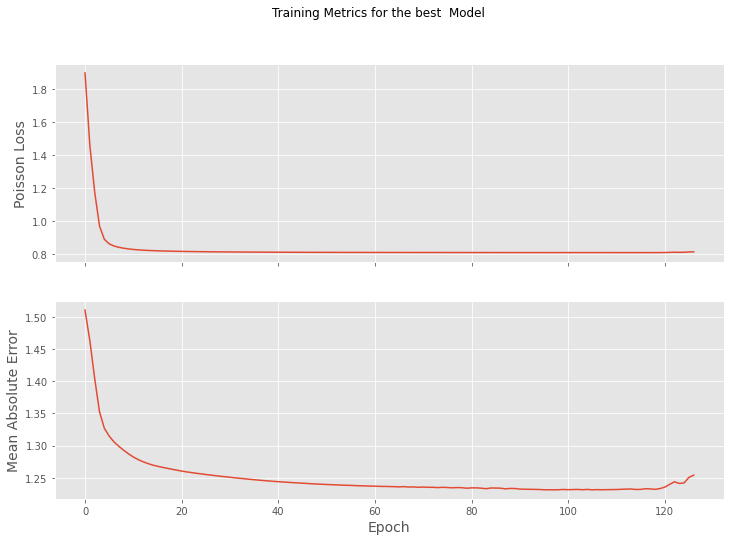

In [14]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics for the best  Model')

axes[0].set_ylabel("Poisson Loss", fontsize=14)
axes[0].plot(best_history['loss'])

axes[1].set_ylabel("Mean Absolute Error", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(best_history['mae'])
plt.show()

In [0]:
# a Funciton to create a dataset with X and the prediction of X
def x_with_preds(X,model):
    x_df = pd.DataFrame(X.numpy())
    preds = (model(X,training=False)).numpy()
    x_df['pred'] = preds
    return x_df

In [0]:
## Compute test loss for the best model
test_loss_results = []
test_accuracy_results = []

model = best_model
test_loss_avg = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()
for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout). = 
    test_loss_avg.update_state(loss(model, x, y, training=False))
    test_accuracy.update_state(y, model(x, training=False))
test_loss_results.append(test_loss_avg.result())
test_accuracy_results.append(test_accuracy.result())

In [17]:
print("Test set MAE of best Model: {:.5}".format(test_accuracy_results[0]))
print("Test set Poisson Loss of best Model: {:.5}".format(test_loss_results[0]))

Test set MAE of best Model: 0.037441
Test set Poisson Loss of best Model: 0.41738


In [0]:
# Creating a combined dataset with the input and the predictions and then picking the top 20 states with the highest change in the incident rate percentage
pred_df = pd.concat(x_with_preds(x,model) for (x,y) in test_dataset)
values_pred,indices_pred = tf.math.top_k(pred_df['pred'],k=104)
indices_pred = np.asarray(indices_pred)

values,indices = tf.math.top_k(y_te['Weekly_Incident_Rate_Pct_Change'],k=104)
indices = np.asarray(indices)

top20 = pd.DataFrame()
top20['Predicted_Province_State'] = pd.Series([X_te.loc[i,'Province_State'] for i in indices_pred]).unique()[0:20]
top20['Actual_Province_State'] = pd.Series([X_te.loc[i,'Province_State'] for i in indices]).unique()[0:20]

In [20]:
print('Top 20 States with highest incident rate change between May 10 to May 24')
top20

Top 20 States with highest incident rate change between May 10 to May 24


,Predicted_Province_State,Actual_Province_State
0,Minnesota,Minnesota
1,Nebraska,North Dakota
2,Iowa,Virginia
3,Kansas,Arizona
4,Puerto Rico,North Carolina
5,Arizona,Nebraska
6,North Carolina,Arkansas
7,Wisconsin,Texas
8,District of Columbia,Alabama
9,New Mexico,Wisconsin


In [21]:
true = top20['Predicted_Province_State'].isin(top20['Actual_Province_State'])
print(len(np.where(true == True)[0]),'out of Top 20 States are predicted correctly')

15 out of Top 20 States are predicted correctly


### Our Best Model, could predict the top 20 states with the highest incident rate percentage change over the final 2 weeks in the test set. 15 of these states actually match the Actual states with the highest change in the incident rate between May 10-24.